## Импорт библиотек и объявление констант

In [1]:
#pip install catboost

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.pipeline import Pipeline


from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.preprocessing import (StandardScaler,
                                   OrdinalEncoder,
                                   OneHotEncoder)


from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.metrics import (make_scorer,
                             roc_auc_score
                            )
from sklearn.preprocessing import FunctionTransformer

from sklearn.metrics import (confusion_matrix,
                             roc_curve,
                             auc)

from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.dummy import DummyRegressor

import ast
TEST_SIZE = 0.25
RANDOM_STATE = 666

In [49]:
# import sys
# !{sys.executable} -m pip freeze > requirements.txt


In [50]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format','{:.4f}'.format)

custom_palette = [
    '#2A5CAA',  # глубокий синий
    '#E63946',  # яркий красный
    '#8B0000',  # тёмно-красный   
    '#457B9D',  # мягкий сине-бирюзовый
    '#A8DADC',  # нежный бирюзовый
    '#F1FAEE',  # молочный белый
    '#B53844',  # глиняный тёплый красный
    '#3A3A3A'   # глубокий графит
]




sns.set_palette(custom_palette)

## Загрузка данных

In [51]:
messages = pd.read_csv('filtered_data/apparel-messages.csv',parse_dates=['date','created_at'])
purchases = pd.read_csv('filtered_data/apparel-purchases.csv',parse_dates=['date'])
target = pd.read_csv('filtered_data/apparel-target_binary.csv')
daily_event_1 = pd.read_csv('filtered_data/full_campaign_daily_event_channel.csv',parse_dates=['date'])
daily_event_2 = pd.read_csv('filtered_data/full_campaign_daily_event.csv',parse_dates=['date'])

### Ознакомление с данными

In [52]:
messages.head(10)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52
5,4439,1515915625594606468,1515915625594606468-4439-6283411f277fc,open,email,2022-05-19,2022-05-19 01:04:11
6,4439,1515915625491810918,1515915625491810918-4439-6283411d9d299,open,email,2022-05-19,2022-05-19 01:19:54
7,4439,1515915625474219766,1515915625474219766-4439-628341212233a,open,email,2022-05-19,2022-05-19 01:23:43
8,4439,1515915625474219766,1515915625474219766-4439-628341212233a,click,email,2022-05-19,2022-05-19 01:24:16
9,4439,1515915625566741491,1515915625566741491-4439-6283412871599,open,email,2022-05-19,2022-05-19 01:31:06


In [53]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB


In [54]:
purchases.head(10)

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0000,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0000,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0000,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0000,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0000,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843
5,1515915625471640575,1,3499.0000,"['2', '18', '258', '441']",2022-05-16,1515915625471640575-4301-627b661b67ac3
6,1515915625490211585,1,1699.0000,"['2', '18', '341', '1311']",2022-05-16,1515915625490211585-4301-627b661843283
7,1515915625490739153,1,1999.0000,"['2', '18', '123', '451']",2022-05-16,1515915625490739153-4172-626b943cc789b
8,1515915625491478747,1,999.0000,"['5562', '5631', '5549', '667']",2022-05-16,1515915625491478747-4273-6274ceb769d59
9,1515915625491651493,1,699.0000,"['5562', '5630', '5649', '678']",2022-05-16,1515915625491651493-4437-6282242f2a9e2


In [55]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


In [56]:
target.head()

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


In [57]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


In [58]:
daily_event_1.head()

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,count_unsubscribe_email,nunique_click_email,nunique_click_mobile_push,nunique_open_email,nunique_open_mobile_push,nunique_purchase_email,nunique_purchase_mobile_push,nunique_soft_bounce_email,nunique_subscribe_email,nunique_unsubscribe_email,count_hard_bounce_mobile_push,count_send_mobile_push,nunique_hard_bounce_mobile_push,nunique_send_mobile_push,count_hard_bounce_email,count_hbq_spam_email,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [59]:
daily_event_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   date                             131072 non-null  datetime64[ns]
 1   bulk_campaign_id                 131072 non-null  int64         
 2   count_click_email                131072 non-null  int64         
 3   count_click_mobile_push          131072 non-null  int64         
 4   count_open_email                 131072 non-null  int64         
 5   count_open_mobile_push           131072 non-null  int64         
 6   count_purchase_email             131072 non-null  int64         
 7   count_purchase_mobile_push       131072 non-null  int64         
 8   count_soft_bounce_email          131072 non-null  int64         
 9   count_subscribe_email            131072 non-null  int64         
 10  count_unsubscribe_email          131072 non-

In [60]:
daily_event_2.head()

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,count_unsubscribe,nunique_click,nunique_complain,nunique_hard_bounce,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [61]:
daily_event_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   date                 131072 non-null  datetime64[ns]
 1   bulk_campaign_id     131072 non-null  int64         
 2   count_click          131072 non-null  int64         
 3   count_complain       131072 non-null  int64         
 4   count_hard_bounce    131072 non-null  int64         
 5   count_open           131072 non-null  int64         
 6   count_purchase       131072 non-null  int64         
 7   count_send           131072 non-null  int64         
 8   count_soft_bounce    131072 non-null  int64         
 9   count_subscribe      131072 non-null  int64         
 10  count_unsubscribe    131072 non-null  int64         
 11  nunique_click        131072 non-null  int64         
 12  nunique_complain     131072 non-null  int64         
 13  nunique_hard_b

### Промежуточный вывод после ознакомления с данными
* Названия столбцов стилистически корректны
* Пропуски отсутствуют
* Даты были сразу преобразованы из строкового формата в datetime



## Создание единого датасета

In [62]:
# объединение
df = purchases.merge(
    messages,
    on=['client_id', 'message_id'],
    how='inner').merge(target, on='client_id', how='inner')
df = df.rename(columns={'date_x': 'date_purchase', 'date_y': 'date_message'})

df.shape

(805820, 12)

In [63]:
df.head()

,client_id,quantity,price,category_ids,date_purchase,message_id,bulk_campaign_id,event,channel,date_message,created_at,target
0,1515915625490739153,1,1999.0000,"['2', '18', '123', '451']",2022-05-16,1515915625490739153-4172-626b943cc789b,4172,open,email,2022-05-27,2022-05-27 07:52:08,0
1,1515915625491869271,2,599.0000,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f,2090,click,email,2023-04-12,2023-04-12 08:25:33,0
2,1515915625491869271,2,599.0000,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f,2090,click,email,2023-04-18,2023-04-18 11:47:45,0
3,1515915625491869271,2,599.0000,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f,2090,click,email,2023-06-13,2023-06-13 11:10:41,0
4,1515915625491869271,2,599.0000,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f,2090,click,email,2023-12-28,2023-12-28 11:25:50,0


### Промежуточный вывод по объединению данных
* В выборку попали только те покупки, для которых есть соответствующее сообщение
* Теперь у каждой записи есть информация, совершил ли покупку клиент или нет.
* Получился единый датасет df, содержащий:
    * информацию о покупках
    * информацию о рассылках
    * целевой признак.
* Такой формат данных позволяет:
    * связать взаимодействия клиента с кампаниями и его поведение,
    * строить признаки на основе дат, событий и каналов,
    * анализировать конверсии рекламных кампаний.
* Размер итогового датасета (df.shape) показывает, сколько уникальных клиент–сообщение–покупка записей мы теперь можем использовать для построения модели.

## Предобработка данных

In [64]:
# Преобразуем строки в списки

df['category_ids'] = df['category_ids'].apply(ast.literal_eval)

In [65]:
# Посмотрим 0на пропущенные значения

bad_mask = df['category_ids'].isna() | \
           df['category_ids'].apply(lambda x: isinstance(x, list) and (len(x) == 0 or x == [None]))

bad_rows = df.loc[bad_mask]

bad_rows.head()
bad_rows.shape[0]

22996

In [66]:
# 11029 строк без категории, удалим их

df = df.drop(bad_rows.index,axis=0)

#### Работа с category_ids
* На первом месте списков находится 8 уникальных значений.
    * Предположим, что это основные категории, как например "распродажа", "для него", "для неё" и т.д
* Эти значения вынесем в отдельный столбец
* Если посмотреть на количество уникальных значений на каждой позииции списка, то можно увидеть, что с ростом индекса, количество значений растет

In [67]:
# Посмотрим на количество уникальных значений на первом месте списка

len(df['category_ids'].str[0].unique())

8

In [68]:
len(df['category_ids'].str[1].unique())

31

In [69]:
len(df['category_ids'].str[2].unique())

291

In [70]:
len(df['category_ids'].str[3].unique())

837

In [71]:
len(df['category_ids'].str[-1].unique())

840

In [72]:
# Часть признаков создам здесь, так как в дальнейшем списки преобразую обратно в строки. 
df['first_cat'] = df['category_ids'].str[0]
df['second_cat'] = df['category_ids'].str[1]
df['third_cat'] = df['category_ids'].str[2]
df['last_cat'] = df['category_ids'].str[-1]

In [73]:
df['category_ids'] = df['category_ids'].apply(lambda x: ",".join(x) if isinstance(x, list) else str(x))


In [74]:
dups = df[df.duplicated(keep=False)]
print(len(dups))
dups.sort_values(by=df.columns.tolist()).head()


498275


,client_id,quantity,price,category_ids,date_purchase,message_id,bulk_campaign_id,event,channel,date_message,created_at,target,first_cat,second_cat,third_cat,last_cat
15633,1515915625468060902,1,199.0000,"4,27,176,458",2022-05-27,1515915625468060902-4617-6290657dac196,4617,click,email,2022-05-27,2022-05-27 10:59:04,0,4,27,176,458
15677,1515915625468060902,1,199.0000,"4,27,176,458",2022-05-27,1515915625468060902-4617-6290657dac196,4617,click,email,2022-05-27,2022-05-27 10:59:04,0,4,27,176,458
15634,1515915625468060902,1,199.0000,"4,27,176,458",2022-05-27,1515915625468060902-4617-6290657dac196,4617,click,email,2022-05-27,2022-05-27 11:22:53,0,4,27,176,458
15678,1515915625468060902,1,199.0000,"4,27,176,458",2022-05-27,1515915625468060902-4617-6290657dac196,4617,click,email,2022-05-27,2022-05-27 11:22:53,0,4,27,176,458
15637,1515915625468060902,1,199.0000,"4,27,176,458",2022-05-27,1515915625468060902-4617-6290657dac196,4617,click,email,2022-05-27,2022-05-27 11:35:07,0,4,27,176,458


***Это явные дубликаты, вплоть до секунды в столбце created_at, можно удалить***

In [75]:
df = df.drop_duplicates()

In [76]:
df.shape

(491096, 16)

### Промежуточный вывод по предобработке данных
* В ходе предобработки были удалены явные дубликаты
* Обработаны значения в category_ids значения развернуты в новые столбцы
* Удалены строки с пропусками и None в столбце category_ids

## EDA

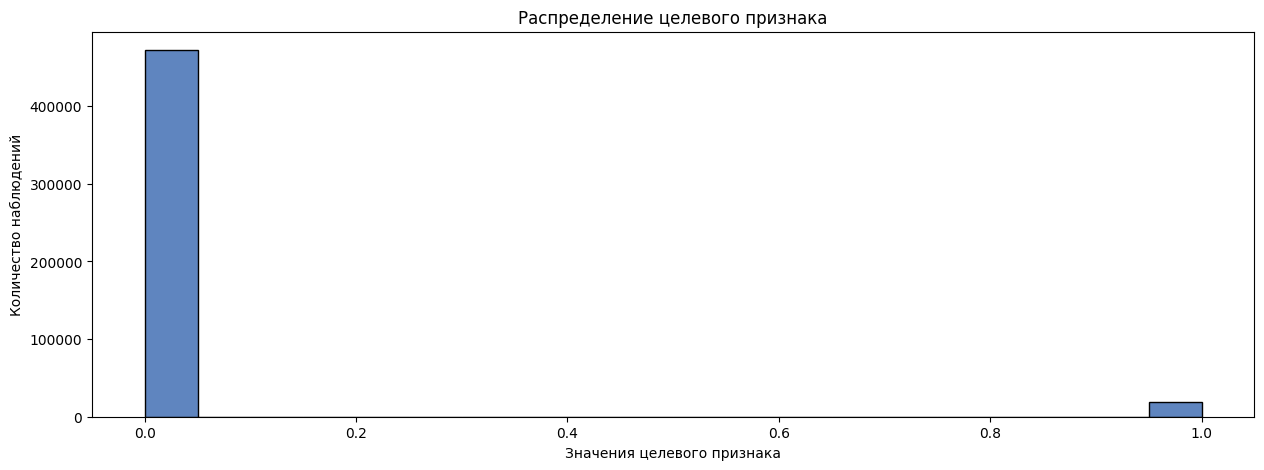

In [77]:
# Распределение таргета
plt.figure(figsize=(15,5))
sns.histplot(df['target'])
plt.title('Распределение целевого признака')
plt.xlabel('Значения целевого признака')
plt.ylabel('Количество наблюдений');

In [78]:
df['target'].value_counts()

target
0    472259
1     18837
Name: count, dtype: int64

***Сильный дисбаланс классов***

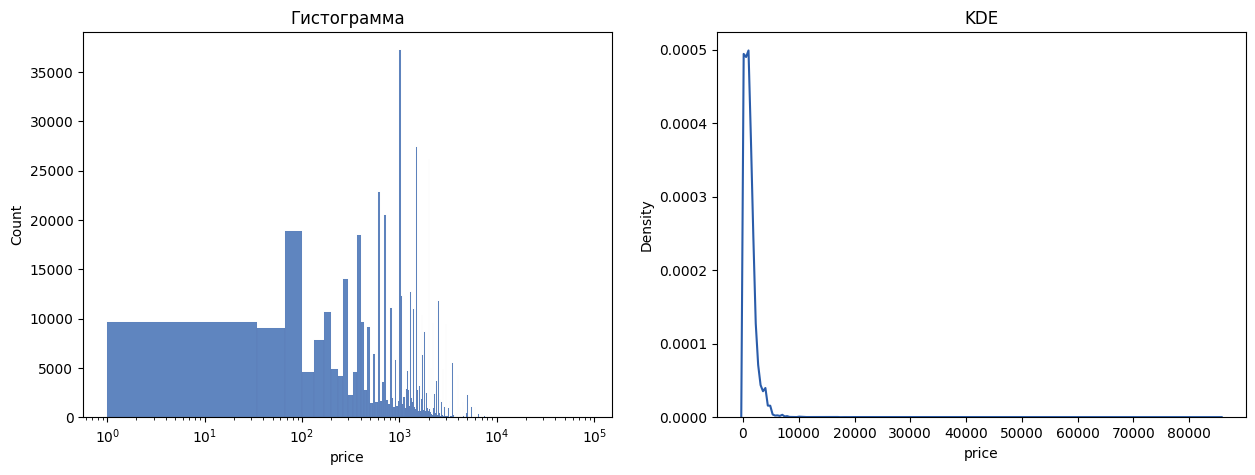

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

sns.histplot(df['price'], ax=axes[0])
axes[0].set_xscale('log')
axes[0].set_title("Гистограмма")

sns.kdeplot(df['price'], ax=axes[1])
axes[1].set_title("KDE")
axes[1].set_xticks(np.arange(0, 90_000, 10_000))
plt.show()

***Распределение с тяжелым хвостом справа. Большинство покупок в ценовом диапазоне до 100 рублей. В диапазоне от 100 до 1000 рублей на гистограмме видно множество шипов, это либо стандартные цены на популярные товары, либо округление цен. Начиная с 10 000 рублей количество покупок резко падает***

In [80]:
df['quantity'].unique()

array([ 1,  2,  3, 25, 13,  4, 10, 30, 18,  8, 15,  6,  9,  5,  7])

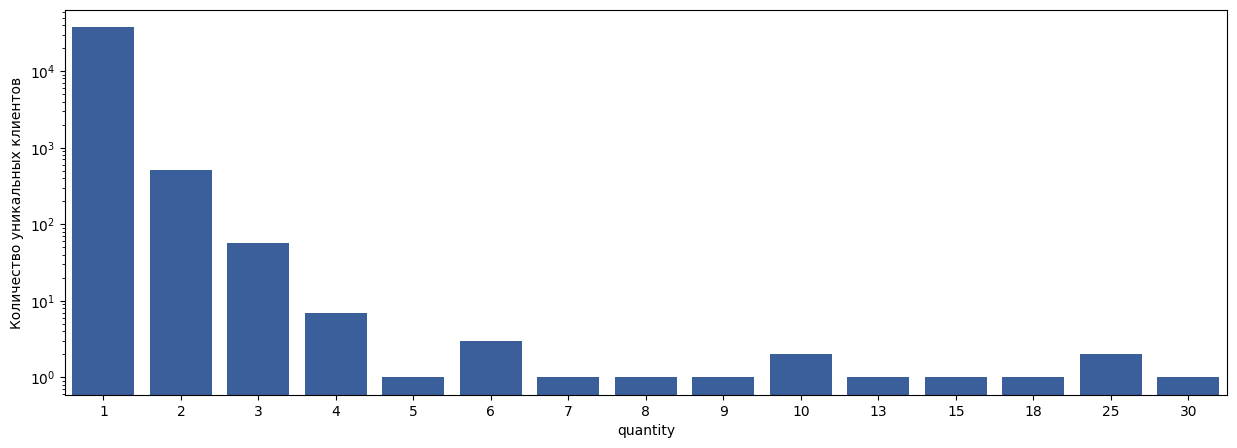

In [81]:
plt.figure(figsize=(15,5))
client_counts = df.groupby('quantity')['client_id'].nunique()
sns.barplot(
    data=client_counts.reset_index(),
    x='quantity', y='client_id'
)
plt.ylabel("Количество уникальных клиентов")
plt.yscale('log')
plt.show()

***чаще всего люди заказывают по одной единице товара***

In [82]:
len(df['bulk_campaign_id'].unique())

1526

***Всего было проведено 1526 рекламных кампаний***

In [83]:
target_stats = (
    df.groupby('bulk_campaign_id')['target']
      .agg(['mean', 'sum', 'count'])
      .rename(columns={
          'mean': 'success_rate',
          'sum': 'num_success',
          'count': 'total_records'
      })
)

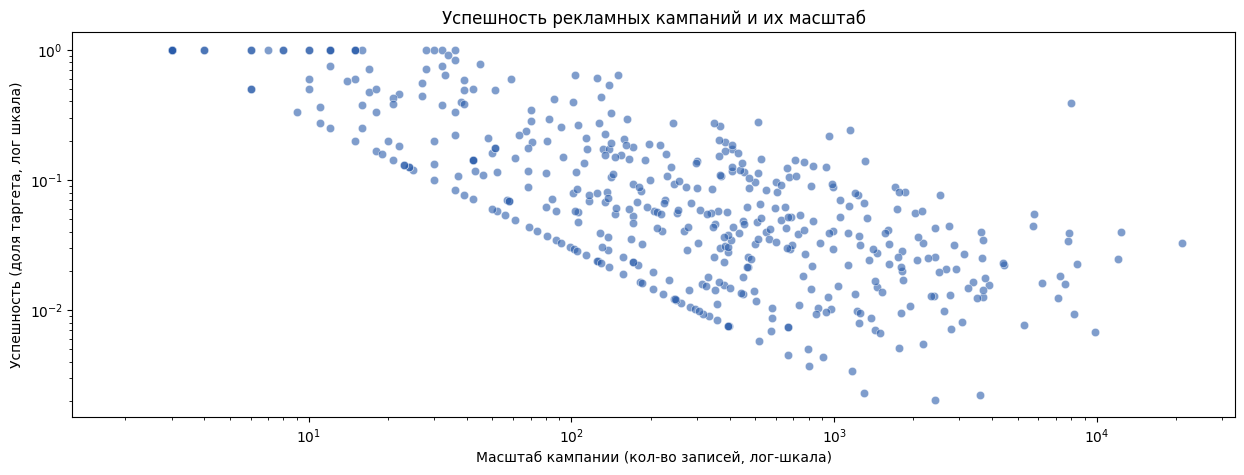

In [84]:
plt.figure(figsize=(15,5))
sns.scatterplot(
    data=target_stats,
    x='total_records', y='success_rate',
    alpha=0.6
)
plt.xscale('log') 
plt.yscale('log')
plt.title("Успешность рекламных кампаний и их масштаб")
plt.xlabel("Масштаб кампании (кол-во записей, лог-шкала)")
plt.ylabel("Успешность (доля таргета, лог шкала)")
plt.show()


***Линейная зависимость. С увеличением масштаба рекламной кампании её эффективность падает. Однако, есть несколько масштабных кампаний с высокой эффективностью***

In [85]:
target_stats = target_stats.loc[target_stats['total_records']>1000].sort_values('success_rate', ascending=False)

target_stats.head(10)

,success_rate,num_success,total_records
bulk_campaign_id,,,
4981,0.3926,3139,7996
13417,0.2426,278,1146
12382,0.1399,183,1308
7818,0.0884,151,1709
14623,0.0805,142,1765
8169,0.0804,150,1866
14356,0.0796,96,1206
12252,0.0772,95,1230
13319,0.0765,194,2535


In [86]:
len(df['client_id'].unique())

37545

***37545 уникальных id клиентов***

In [87]:
user_stats = df.groupby('client_id')['target'].agg(['sum','mean','count']).sort_values('sum',ascending=False)
active_users = user_stats.loc[user_stats['sum']>0]
print(f"Доля активных пользовтелей: {round(len(active_users)/len(user_stats) *100,2)}%")
user_stats

Доля активных пользовтелей: 2.02%


,sum,mean,count
client_id,,,
1515915625490334876,2849,1.0000,2849
1515915625588831252,388,1.0000,388
1515915625470860261,324,1.0000,324
1515915625491750681,281,1.0000,281
1515915625489401199,247,1.0000,247
...,...,...,...
1515915626009879311,0,0.0000,12
1515915626009932400,0,0.0000,4
1515915626010079153,0,0.0000,21


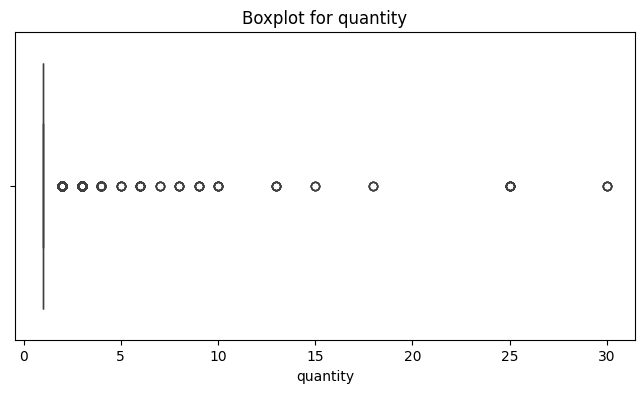

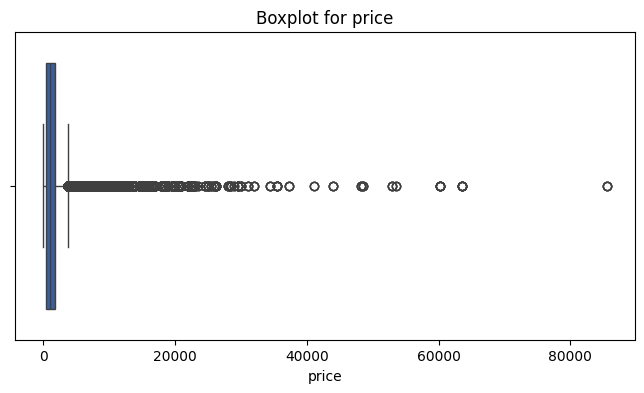

In [88]:
num_features = df.select_dtypes(include='number').drop(columns=['client_id', 'target','bulk_campaign_id'])

for col in num_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot for {col}')
    plt.show()

***С выбросами ничего делать не будем***

In [89]:
len(df['message_id'].unique())

44058

***В данных 44059 уникальных id сообщений***

In [90]:
print(f'Стартовая дата заказов: {df['date_purchase'].min()}')
print(f'Конечная дата заказов: {df['date_purchase'].max()}')

Стартовая дата заказов: 2022-05-16 00:00:00
Конечная дата заказов: 2024-02-16 00:00:00


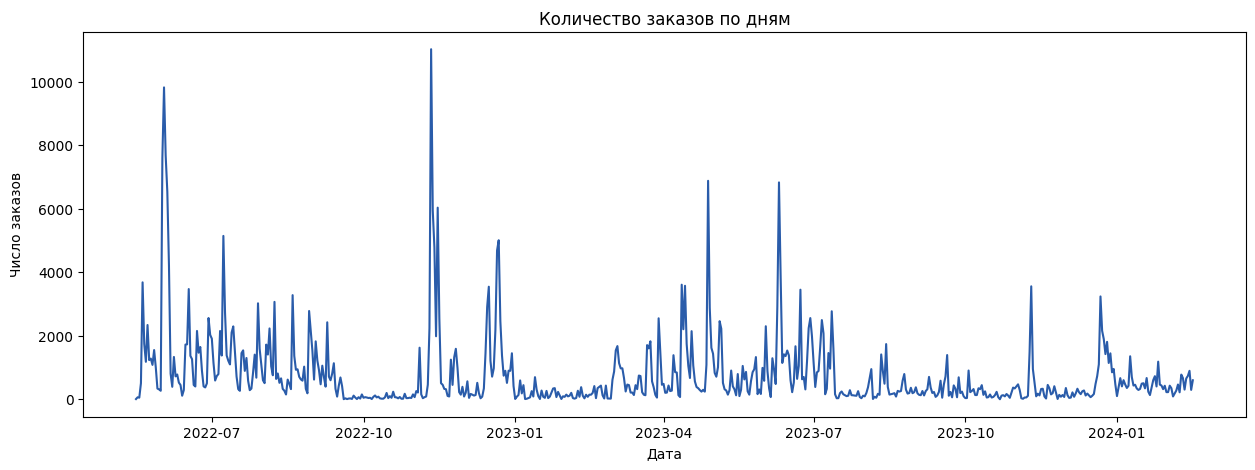

In [91]:
orders_by_day = df.groupby(df['date_purchase'].dt.date).size()

plt.figure(figsize=(15,5))
orders_by_day.plot()
plt.title("Количество заказов по дням")
plt.xlabel("Дата")
plt.ylabel("Число заказов")
plt.show()


In [92]:
print(f'Стартовая дата сообщений: {df['created_at'].min()}')
print(f'Конечная дата сообщений: {df['created_at'].max()}')

Стартовая дата сообщений: 2022-05-19 01:50:17
Конечная дата сообщений: 2024-02-15 23:51:20


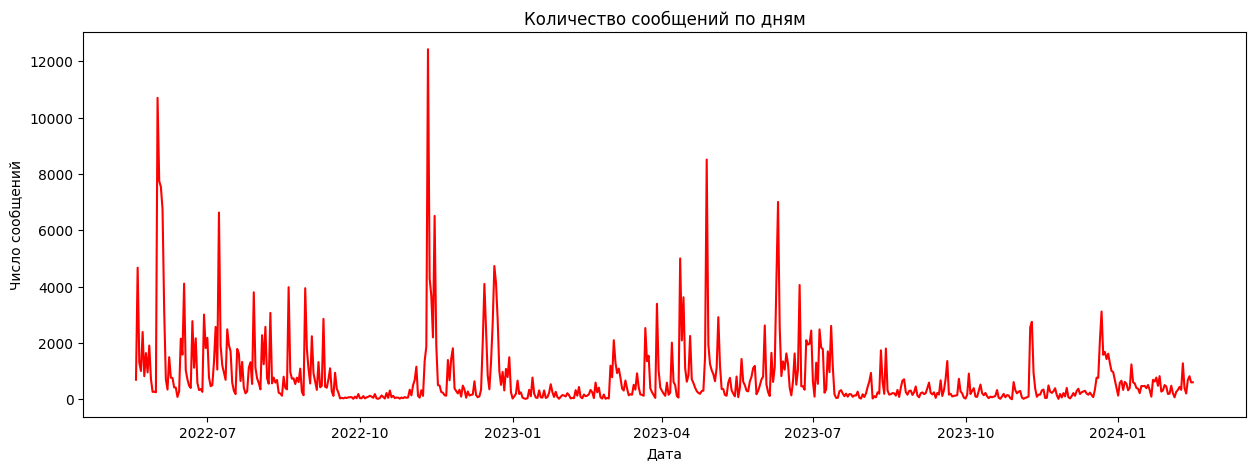

In [93]:
messages_by_day = df.groupby(df['created_at'].dt.date).size()

plt.figure(figsize=(15,5))
messages_by_day.plot(color='red')
plt.title("Количество сообщений по дням")
plt.xlabel("Дата")
plt.ylabel("Число сообщений")
plt.show()

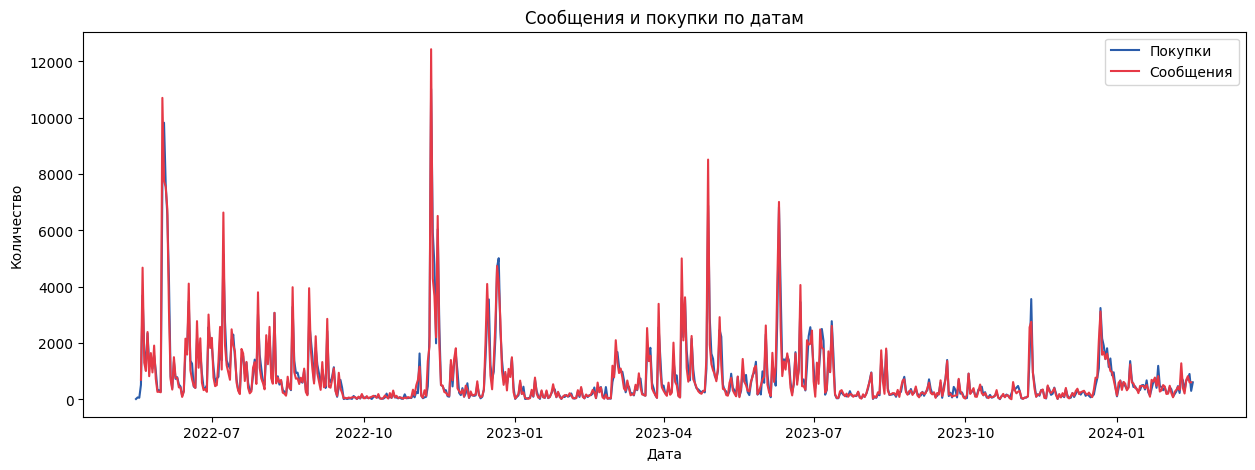

In [94]:
plt.figure(figsize=(15,5))
orders_by_day.plot(label="Покупки")
messages_by_day.plot(label="Сообщения")
plt.title("Сообщения и покупки по датам")
plt.xlabel("Дата")
plt.ylabel("Количество")
plt.legend()
plt.show()


***Практически одинаковые графики, здесь может быть утечка целевого признака***

In [95]:
print(f"Всего записей в столбце: {df['event'].shape}")
df['event'].value_counts()

Всего записей в столбце: (491096,)


event
click          169234
purchase       141159
send            92650
open            87715
hard_bounce       236
unsubscribe        69
complain           26
subscribe           7
Name: count, dtype: int64

* send — система отправила письмо

* open — «открытие» письма

* click — клик по трекаемому URL из письма.

* purchase — конверсия/покупка

* hard_bounce — постоянная недоставка: несуществующий адрес, домен, запрет приёма

* unsubscribe — пользователь отписался (по ссылке в письме или через профиль)

* complain — жалоба на спам (feedback loop от провайдера)

* subscribe — новая подписка

***В этом столбце так же может быть утечка признака в значении *purchase****

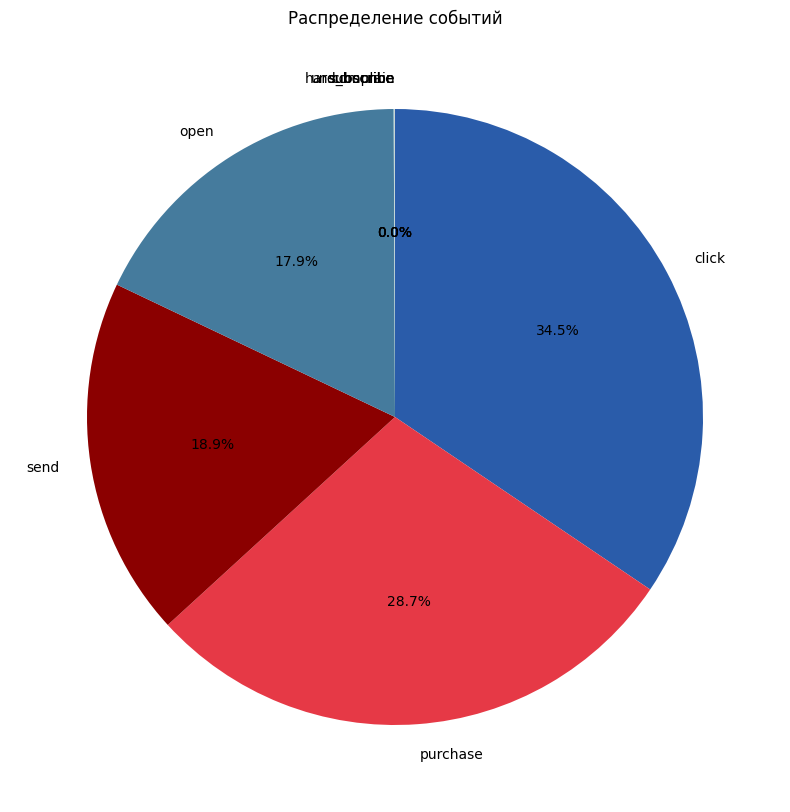

In [96]:
event_counts = df['event'].value_counts()

plt.figure(figsize=(10,10))
plt.pie(
    event_counts, 
    labels=event_counts.index, 
    autopct='%1.1f%%', 
    startangle=90, 
    counterclock=False
)
plt.title("Распределение событий")
plt.show()


***Почти 30% пользователей совершают покупки после получения рекламного сообщения***

In [97]:
df['channel'].value_counts()

channel
email          359943
mobile_push    131153
Name: count, dtype: int64

***Электронных писем почти в три раза больше, чем пуш уведомлений***

In [98]:
channel_event = pd.pivot_table(
    df,
    index='event',
    columns='channel',     
    aggfunc='size',        
    fill_value=0
)
channel_event.sort_values(by='email',ascending=False)


channel,email,mobile_push
event,,
click,129969,39265
purchase,90028,51131
open,80399,7316
send,59445,33205
unsubscribe,69,0
complain,26,0
subscribe,7,0
hard_bounce,0,236


<Figure size 1500x500 with 0 Axes>

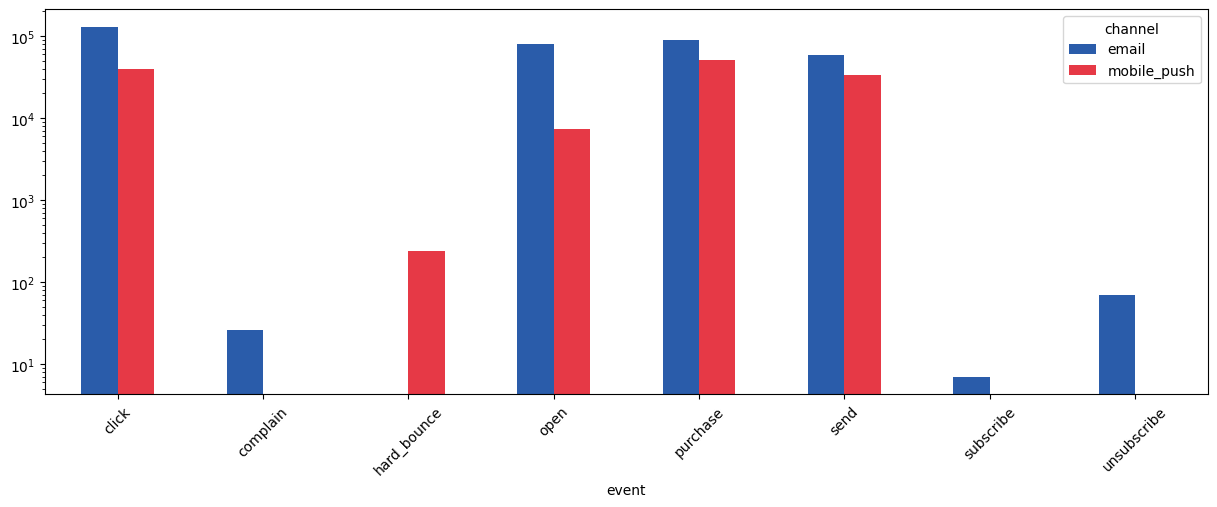

In [99]:
plt.figure(figsize=(15,5))

channel_event.plot(kind="bar", rot=45,figsize=(15,5))
plt.yscale("log")  # лог-шкала, т.к. диапазон значений большой



In [100]:
df['first_cat'].value_counts()

first_cat
4       290633
5562    109581
2        74317
6060     13705
5963      2798
3           29
1           23
5           10
Name: count, dtype: int64

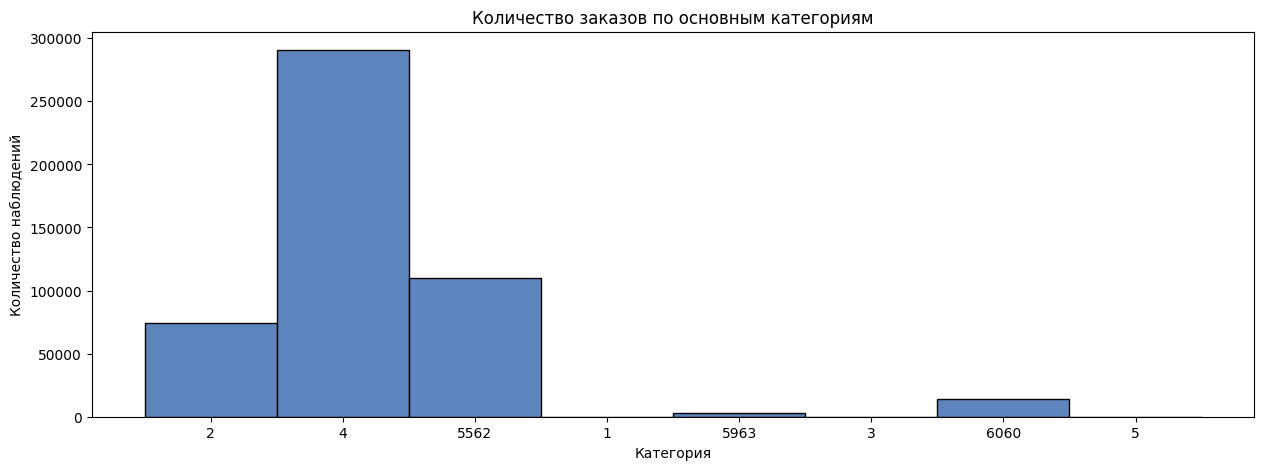

In [101]:
plt.figure(figsize=(15,5))
sns.histplot(df['first_cat'])
plt.title('Количество заказов по основным категориям')
plt.xlabel('Категория')
plt.ylabel('Количество наблюдений');

In [102]:
orders_by_cat = (
    df.groupby([df['date_purchase'].dt.to_period('M'), 'first_cat'])
      .size()
      .reset_index(name='num_orders')
)

# превращаем Period в Timestamp (для графика)
orders_by_cat['date'] = orders_by_cat['date_purchase'].dt.to_timestamp()


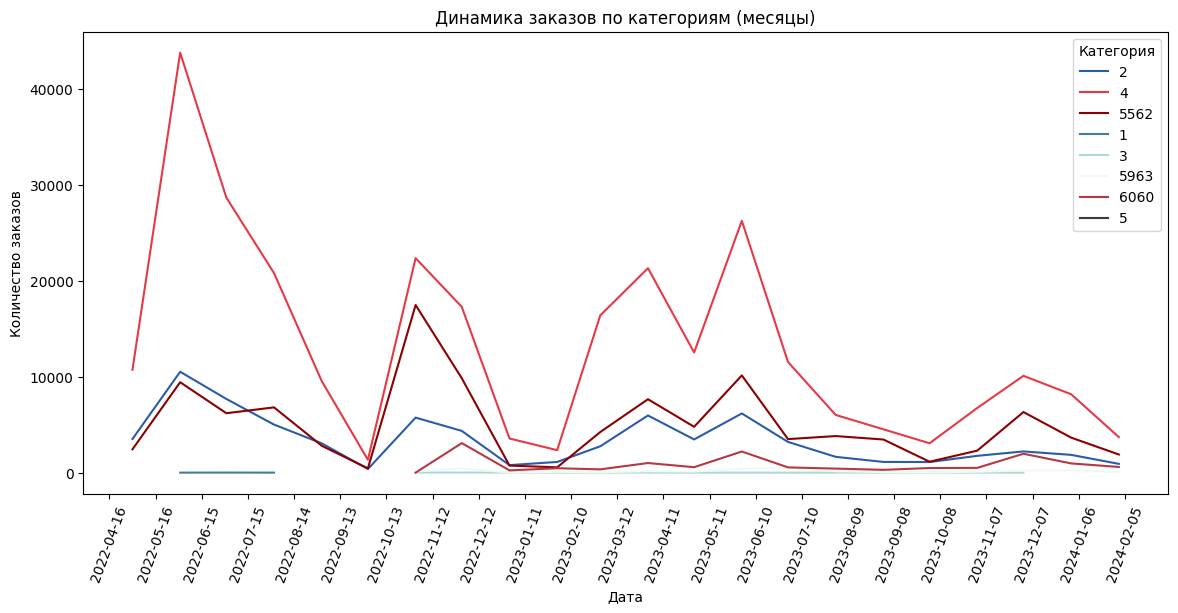

In [103]:
plt.figure(figsize=(14,6))
sns.lineplot(
    data=orders_by_cat,
    x='date', y='num_orders',
    hue='first_cat'
)
plt.title("Динамика заказов по категориям (месяцы)")
plt.xlabel("Дата")
plt.ylabel("Количество заказов")
plt.legend(title="Категория")
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=70);


## Добавление признаков

In [104]:
df = df.copy()
df['purchase_dayofweek'] = df['date_purchase'].dt.dayofweek
df['purchase_month'] = df['date_purchase'].dt.month


df['lag_message_purchase'] = (df['date_purchase'] - df['created_at']).dt.total_seconds() / 3600
df['total_sum'] = df['price'] * df['quantity']

In [105]:
interactions = df.groupby('client_id')['message_id'].nunique().reset_index()
interactions = interactions.rename(columns={'message_id': 'num_interactions'})

interactions_channel = (
    df.groupby(['client_id', 'channel'])['message_id']
      .nunique()
      .unstack(fill_value=0)
      .reset_index()
      .rename(columns={'email': 'num_email', 'mobile_push': 'num_push'})
)

df = df.merge(interactions, on='client_id', how='left')
df = df.merge(interactions_channel, on='client_id', how='left')


In [106]:
df = df.fillna(0)

## Построение моделей

In [107]:
df = df.drop(columns=['event',            # event удаляем из-за возможной утечки целевого признака, т.к. в нем содержится "purchase"
                      'bulk_campaign_id', # Идентификатор рекламной кампании удаляем, из-за того, что в будущем у нас этих кампаний не будет
                      'quantity',         # Удалено после анализа permutation_importance
                      'first_cat',        # Удалено после анализа permutation_importance
                      'second_cat',       # Удалено после анализа permutation_importance
                      'channel',          # Удалено после анализа permutation_importance
                      'client_id',        # Удаляем, потому что хотим посторить модель, которая основывается на поведении клиента, а не запоминает id
                      'message_id',       # В будущем у каждого сообщения будут новые id
                      'date_purchase',    # Не привязываем модель  к конкретным датам. 
                      'date_message',     # Не привязываем модель  к конкретным датам.
                      'created_at'        # Не привязываем модель  к конкретным датам.
                     ])     

In [142]:
X = df.drop(columns='target')
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

In [143]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491096 entries, 0 to 491095
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   price                 491096 non-null  float64
 1   category_ids          491096 non-null  object 
 2   third_cat             491096 non-null  object 
 3   last_cat              491096 non-null  object 
 4   purchase_dayofweek    491096 non-null  int32  
 5   purchase_month        491096 non-null  int32  
 6   lag_message_purchase  491096 non-null  float64
 7   total_sum             491096 non-null  float64
 8   num_interactions      491096 non-null  int64  
 9   num_email             491096 non-null  int64  
 10  num_push              491096 non-null  int64  
dtypes: float64(3), int32(2), int64(3), object(3)
memory usage: 37.5+ MB


In [172]:
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Числовые:", num_features)
print("Категориальные:", cat_features)

# так как используем бустинг, то применям OE чтобы не раздувать признаковое пространство как с ОНЕ

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_features)
])


cat_model = CatBoostClassifier(
    verbose=0,
    random_state=42
)


pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', cat_model)
])


param_distributions = {
    "model__depth": list(range(3, 11)),  
    "model__iterations": list(range(100, 301, 50)),  
    "model__learning_rate": np.linspace(0.01, 0.1, 10),  
    "model__l2_leaf_reg": np.linspace(0.001, 0.1, 10),  
    "model__subsample": np.linspace(0.5, 0.9, 5),  
    "model__border_count": [32, 64, 128],  
    "model__early_stopping_rounds": [50], 
    "model__auto_class_weights" : ['Balanced']   # Встроенными методами катбуста нивелируем дисбаланс классов.
}


search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=20,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=RANDOM_STATE
)


search.fit(X_train, y_train)

Числовые: ['price', 'purchase_dayofweek', 'purchase_month', 'lag_message_purchase', 'total_sum', 'num_interactions', 'num_email', 'num_push']
Категориальные: ['category_ids', 'third_cat', 'last_cat']
Fitting 3 folds for each of 20 candidates, totalling 60 fits


,estimator,Pipeline(step...7DC375FFB0>)])
,param_distributions,"{'model__auto_class_weights': ['Balanced'], 'model__border_count': [32, 64, ...], 'model__depth': [3, 4, ...], 'model__early_stopping_rounds': [50], ...}"
,n_iter,20
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,666
,error_score,nan


In [173]:
print("Лучшие параметры:", search.best_params_)
print()
print("Лучший ROC AUC (CV):", search.best_score_)
print()
y_pred = search.predict(X_test)
y_pred_proba = search.predict_proba(X_test)[:,1]
print("ROC AUC (test):", roc_auc_score(y_test, y_pred_proba))

Лучшие параметры: {'model__subsample': np.float64(0.9), 'model__learning_rate': np.float64(0.09000000000000001), 'model__l2_leaf_reg': np.float64(0.05600000000000001), 'model__iterations': 250, 'model__early_stopping_rounds': 50, 'model__depth': 10, 'model__border_count': 128, 'model__auto_class_weights': 'Balanced'}

Лучший ROC AUC (CV): 0.9705124226099819

ROC AUC (test): 0.9837241970463106


In [174]:
y_prob_train = search.predict_proba(X_train)[:,1]
print("ROC AUC (train):", roc_auc_score(y_train, y_prob_train))

ROC AUC (train): 0.9944982590263748


<Axes: >

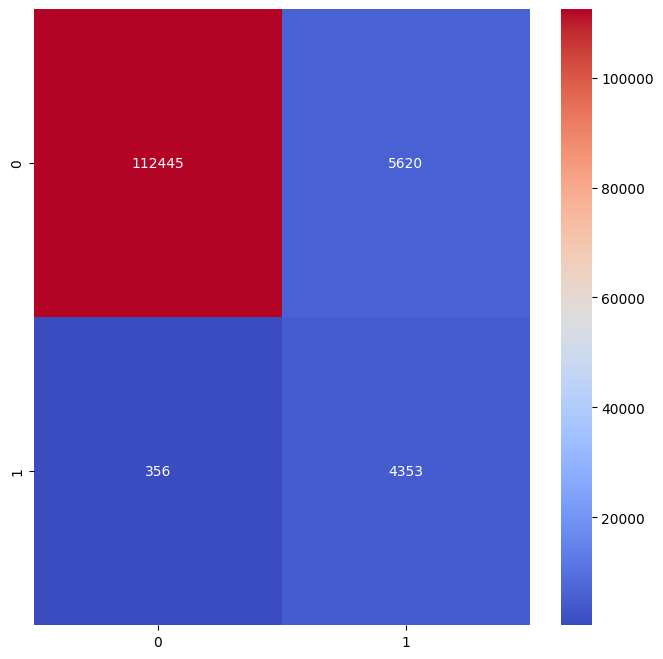

In [175]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt='2g', cmap='coolwarm')

* Модель хорошо определяет клиентов, которые действительно совершают покупку, то есть почти всех «покупателей» она находит.
* Однако точность невысокая, среди предсказанных «покупателей» примерно 2/3 на самом деле не совершат покупку.
    * Это связано с дисбалансом классов

                 feature  importance_mean  importance_std
8       num_interactions           0.1943          0.0025
5         purchase_month           0.1752          0.0014
7              total_sum           0.1734          0.0018
4     purchase_dayofweek           0.1676          0.0024
2              third_cat           0.1451          0.0017
1           category_ids           0.1428          0.0033
0                  price           0.1424          0.0025
3               last_cat           0.0920          0.0014
10              num_push           0.0592          0.0009
9              num_email           0.0534          0.0007
6   lag_message_purchase           0.0214          0.0006


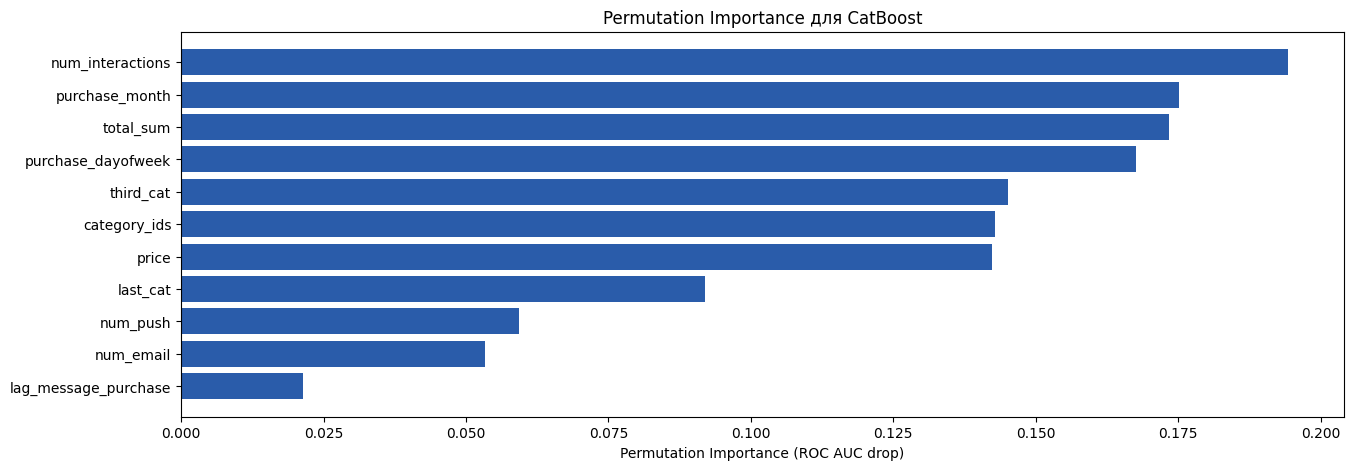

In [176]:
# берём лучший пайплайн 
best_pipe = search.best_estimator_

# считаем permutation importance на тесте
r = permutation_importance(
    best_pipe, X_test, y_test,
    scoring="roc_auc", n_repeats=5, random_state=RANDOM_STATE, n_jobs=-1
)

# в DataFrame для удобства
importances = pd.DataFrame({
    "feature": X_test.columns,
    "importance_mean": r.importances_mean,
    "importance_std": r.importances_std
}).sort_values("importance_mean", ascending=False)

print(importances.head(15))

plt.figure(figsize=(15,5))
plt.barh(importances["feature"], importances["importance_mean"])
plt.gca().invert_yaxis()
plt.xlabel("Permutation Importance (ROC AUC drop)")
plt.title("Permutation Importance для CatBoost")
plt.show()


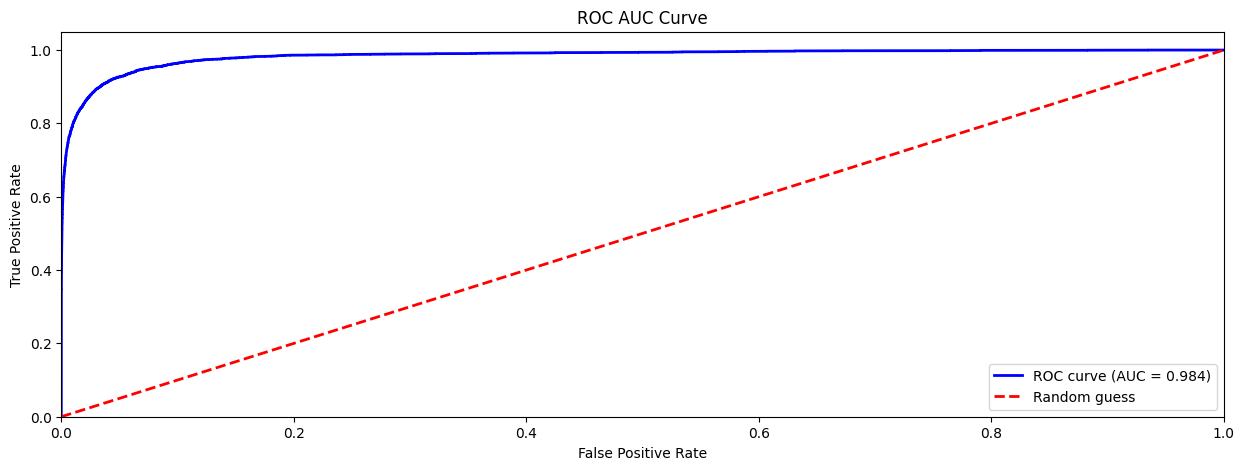

In [177]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(15,5))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color="red", lw=2, linestyle="--", label="Random guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC AUC Curve")
plt.legend(loc="lower right")
plt.show()